In [1]:
import sys
sys.path.append('..')
import sklearn
import wandb
from tsai.basics import *
from swdf.losses import *
from swdf.utils import *
from swdf.metrics import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from itertools import chain

# Training the Solar Drivers F10.7, S10.7, M10.7, and Y10.7 Ensembled Forecaster

In this notebook, we outline the steps for training the forecaster using two learners, each with a different loss function. This approach is used because different loss functions can complement each other, compensating for the deficits of one by correcting them with the strengths of the other, potentially leading to better overall performance.

For more information about the general process of training PatchTST see `solfsmy_train` notebook. In this notebook, we just replicate the work done in the general one but using to learners that can have different parameters.

In [2]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_solfsmy = yaml2dict('./config/solfsmy_ensemble.yaml', attrdict=True)
config_train = config_solfsmy.train
config_data = config_solfsmy.data 

# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base,
                   **config_train, 
                   "data":AttrDict({**config_data})})

# Add the architecture config
if config.learner1.arch_name.lower() == 'patchtst':
    config.learner1.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
    config.learner2.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
else:
    config.arch = AttrDict()

In [3]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config

In [4]:
config

```json
{ 'bs': 32,
  'data': { 'add_time_channels': False,
            'data_columns': ['F10', 'S10', 'M10', 'Y10'],
            'data_nb': './solfsmy_data.ipynb',
            'data_path': '../data/SOLFSMY.TXT',
            'data_time_columns': ['Year', 'DDD'],
            'data_url': 'https://sol.spacenvironment.net/JB2008/indices/SOLFSMY.TXT',
            'df_save_path': './preprocessed_data/dataframes/solfsmy.pkl',
            'exp_pipe_save_path': './preprocessed_data/pipelines/exp_solfsmy.pkl',
            'force_download': False,
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_solfsmy.pkl'},
  'horizon': 6,
  'is_optuna_study': False,
  'learner1': { 'arch': { 'd_model': 1024,
                          'decomposition': True,
                          'dropout': 0.4,
                          'individual': True,
                          'n_heads': 16,
                          'padding_patch': True,
                          'revin': True},
                'arch_config_file': 'config/patchtst.yaml',
                'arch_name': 'PatchTST',
                'init_weights': False,
                'loss_config': {},
                'loss_func': 'wMSE',
                'lr_max': None},
  'learner2': { 'arch': { 'd_model': 1024,
                          'decomposition': True,
                          'dropout': 0.4,
                          'individual': True,
                          'n_heads': 16,
                          'padding_patch': True,
                          'revin': True},
                'arch_config_file': 'config/patchtst.yaml',
                'arch_name': 'PatchTST',
                'init_weights': False,
                'loss_config': {},
                'loss_func': 'wMAE',
                'lr_max': None},
  'lookback': 24,
  'main_metric': 'default',
  'metrics_handler_path': None,
  'n_epoch': 30,
  'partial_n': 0.1,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

## Data Loading

All the information about the data and indices used here can be found in `./solfsmy_data`.

In [5]:
df, preproc_pipe, exp_pipe = generate_preprocessed_data(config.data)

df.head()

,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10,Datetime
0,1997,1,2450450.0,72.400002,78.000000,74.000000,79.199997,65.400002,73.800003,61.900002,70.699997,1B11,1,B,1,1,1997-01-01 12:00:00
1,1997,2,2450451.0,72.099998,77.900002,73.800003,79.099998,66.900002,73.699997,63.400002,70.400002,1B11,1,B,1,1,1997-01-02 12:00:00
2,1997,3,2450452.0,73.300003,77.599998,75.000000,79.099998,70.099998,73.599998,64.900002,70.199997,1B11,1,B,1,1,1997-01-03 12:00:00
3,1997,4,2450453.0,73.800003,77.300003,76.300003,79.000000,71.599998,73.400002,65.500000,69.800003,1B11,1,B,1,1,1997-01-04 12:00:00
4,1997,5,2450454.0,74.400002,76.900002,77.599998,78.900002,72.400002,73.300003,66.699997,69.599998,1B11,1,B,1,1,1997-01-05 12:00:00


## Data Splitting

For the data splitting process, we will evaluate the data based on solar activity categories to ensure that each level is correctly represented in the validation set. This is the same that we did in the original training notebook.

In [6]:
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime

thresholds = yaml2dict("preprocessed_data/categorization/thresholds_solfsmy.yaml")
solact_levels = yaml2dict("preprocessed_data/categorization/activity_levels_solfsmy.yaml")

In [7]:
df_F10 = load_object("./preprocessed_data/dataframes/F10_historical.pkl")

df_F107_cat = get_classified_columns(df_F10, thresholds, activity_levels={'F10': solact_levels['F10']})['F10_Cat']
historical_distribution = df_F107_cat.value_counts(normalize=True).to_dict()

historical_distribution

{'moderate': 0.5065749000307598,
 'low': 0.18390495232236234,
 'high': 0.16145032297754536,
 'elevated': 0.14806982466933252}

In [8]:
test_period = (df.Datetime >= test_start_datetime) & (df.Datetime <= test_end_datetime)

df_cat = get_classified_columns(df, thresholds, solact_levels)
df_cat = df_cat[~(test_period)]

test_size = df[test_period].shape[0] / df.shape[0]
train_val_size = 1 - test_size
val_size = 0.15 / train_val_size
print(f"Test size: {test_size}, Validation size: {val_size}, Train size: {1 - test_size - 0.15}")

best_comb, segments, distribution = find_closest_distribution(df_cat['F10_Cat'], historical_distribution, 250, val_size) 

Test size: 0.23137731833384007, Validation size: 0.19515427215189873, Train size: 0.6186226816661599
Total number of segments:30, Number of segments for validation: 5 (16.67%)


142506it [00:02, 68817.70it/s]

The closest group of segments to F10.7 categories has an euclidean distance of 0.003046653033067287


In [9]:
best_comb_idxs = [segments[i] for i in best_comb]
validation_segments = (df.index.isin(chain.from_iterable(best_comb_idxs)))

train_df = df[~validation_segments & ~test_period] 
train_distribution = get_classified_columns(train_df, thresholds, solact_levels)['F10_Cat'].value_counts(normalize=True).to_dict()

train_distribution

{'moderate': 0.5089412881785093,
 'low': 0.29340085456559584,
 'elevated': 0.1248615287228992,
 'high': 0.07279632853299572}

In [10]:
all_segment_idxs = np.arange(len(segments))
train_comb = list(np.setdiff1d(all_segment_idxs, best_comb))

data_columns = config.data.data_columns

# Validation set
X_val, y_val, split_val = sliding_window_generator(
    df, split_start=0, data_columns=data_columns, config=config, comb=best_comb, segments=segments
)

# Train set
X_train, y_train, split_train = sliding_window_generator(
    df, split_start=split_val[-1] + 1, data_columns=data_columns, config=config, comb=train_comb, segments=segments
)

# Test set
X_test, y_test, split_test = sliding_window_generator(
    df[test_period], split_start=split_train[-1] + 1, data_columns=data_columns, config=config
)

X = np.concatenate([X_val, X_train, X_test])
y = np.concatenate([y_val, y_train, y_test])

splits = (split_train, split_val, split_test)
splits

((#6145) [1120,1121,1122,1123,1124,1125,1126,1127,1128,1129...],
 (#1120) [0,1,2,3,4,5,6,7,8,9...],
 (#2254) [7265,7266,7267,7268,7269,7270,7271,7272,7273,7274...])

## Training the Forecaster

This section implements the entire training process for the forecasting model. We reimplement the weights and splits here, rather than simply loading them from the original FSMY 10.7 indices training notebook, to allow for modifications to the lookback period **during hyperparameter tuning**.


In [11]:
weights = {
    k: np.abs(train_distribution.get(k, 0) - historical_distribution.get(k, 0))
    for k in set(train_distribution) | set(historical_distribution)
}

# Normalize the weights so that their sum equals 1
normalization_factor = 1.0 / sum(weights.values())
weights_raw = {k: v * normalization_factor for k, v in weights.items()}

# Format the weights for the 'All' category to be used in the LossFactory class
weights = {'All': [weights_raw.get(k, 0) for k in solact_levels['F10']]}

weights, weights_raw

({'All': [0.48942276195365547,
   0.010577238046344466,
   0.10373601266930658,
   0.3962639873306933]},
 {'high': 0.3962639873306933,
  'moderate': 0.010577238046344466,
  'elevated': 0.10373601266930658,
  'low': 0.48942276195365547})

epoch,train_loss,valid_loss,Loss_Low,Loss_Moderate,Loss_Elevated,Loss_High,time
0,27.275599,44.707188,1.286004,0.943070,5.225341,37.252769,00:00
1,28.105371,35.163784,0.943174,0.688995,4.436432,29.095175,00:01
2,23.359909,29.606741,0.677588,0.539174,4.124863,24.265123,00:00
3,20.627403,27.561604,0.543491,0.480151,3.666582,22.871382,00:00
4,17.997715,23.691999,0.635698,0.489021,3.022863,19.544422,00:00
5,17.918659,25.949028,0.607385,0.498823,3.423784,21.419041,00:00
6,17.129915,22.493675,0.609792,0.476132,2.984025,18.423727,00:00
7,15.947302,24.949686,0.534971,0.490976,3.394746,20.528992,00:00
8,16.868864,25.094107,0.756799,0.584109,3.933471,19.819723,00:00
9,15.470484,23.055407,0.535753,0.439251,3.210120,18.870281,00:01


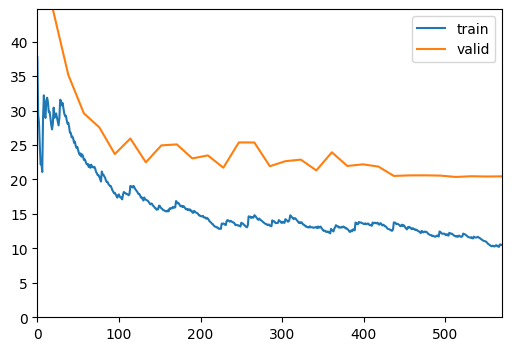

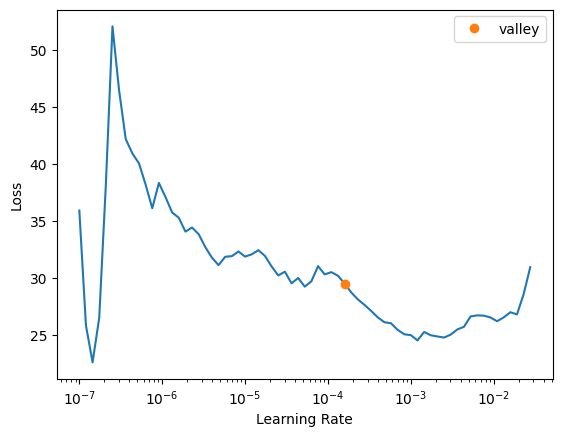

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the loss function with the provided thresholds and weights
loss = LossFactory(thresholds=thresholds, weights=weights).create(
    config.learner1.loss_func, **config.learner1.loss_config
).to(device)

# Set up metrics 
if config.metrics_handler_path is not None:
    metrics_handler = load_object(config.metrics_handler_path)
else:
    metrics_handler = LossMetrics(loss, 'SolFSMY')
metrics = metrics_handler.get_metrics()

# Initialize the callback list, including WandbCallback if enabled
wandb_callback = WandbCallback(log_preds=False)
callbacks = L(wandb_callback) if config.wandb.enabled else L()
callbacks += ShowGraphCallback()

learner1 = TSForecaster(
    X, y, splits=splits, 
    batch_size=config.bs,
    pipelines=[preproc_pipe, exp_pipe], 
    arch=config.learner1.arch_name, 
    metrics=metrics,
    loss_func=loss,
    arch_config=dict(config.learner1.arch), 
    init=config.learner1.init_weights,
    cbs= callbacks, 
    partial_n=config.partial_n)
learner1.to(device)

try: # In some extreme cases it can fail and return an error
    lr_max = learner1.lr_find().valley if config.learner1.lr_max is None else config.learner1.lr_max
except:
    lr_max = 1e-3

learner1.fit_one_cycle(n_epoch=config.n_epoch, lr_max=lr_max)

epoch,train_loss,valid_loss,Loss_Low,Loss_Moderate,Loss_Elevated,Loss_High,time
0,0.987794,1.346733,0.146206,0.037982,0.207835,0.954710,00:00
1,0.905572,1.112379,0.133685,0.032287,0.182187,0.764221,00:00
2,0.824400,1.136697,0.137439,0.033372,0.184332,0.781553,00:01
3,0.791094,1.318832,0.159373,0.037178,0.221902,0.900380,00:00
4,0.841875,1.349203,0.160881,0.039667,0.206695,0.941960,00:01
5,0.867108,1.567396,0.202025,0.051722,0.324513,0.989137,00:01
6,0.882016,1.499448,0.177269,0.043658,0.250624,1.027898,00:00
7,0.891078,1.555798,0.181060,0.046370,0.289128,1.039240,00:01
8,0.880135,1.502259,0.174317,0.045234,0.257079,1.025630,00:01
9,0.892468,1.314453,0.165274,0.040199,0.234739,0.874240,00:00


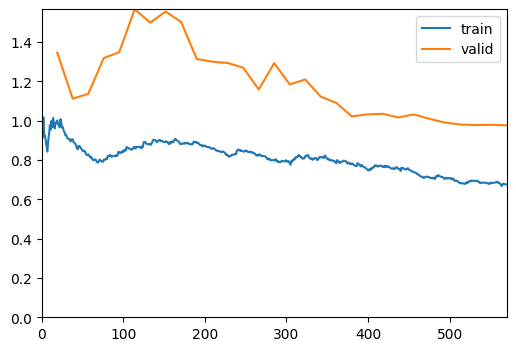

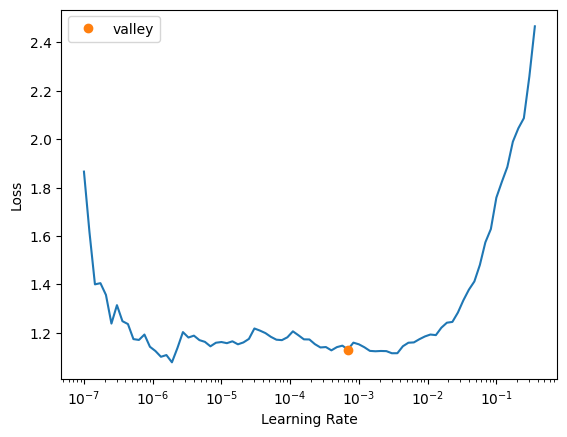

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the loss function with the provided thresholds and weights
loss = LossFactory(thresholds=thresholds, weights=weights).create(
    config.learner2.loss_func, **config.learner2.loss_config
).to(device)

# Set up metrics 
if config.metrics_handler_path is not None:
    metrics_handler = load_object(config.metrics_handler_path)
else:
    metrics_handler = LossMetrics(loss, 'SolFSMY')
metrics = metrics_handler.get_metrics()

# Initialize the callback list, including WandbCallback if enabled
wandb_callback = WandbCallback(log_preds=False)
callbacks = L(wandb_callback) if config.wandb.enabled else L()
callbacks += ShowGraphCallback()

learner2 = TSForecaster(
    X, y, splits=splits, 
    batch_size=config.bs,
    pipelines=[preproc_pipe, exp_pipe], 
    arch=config.learner2.arch_name, 
    metrics=metrics,
    loss_func=loss,
    arch_config=dict(config.learner2.arch), 
    init=config.learner2.init_weights,
    cbs= callbacks, 
    partial_n=config.partial_n)
learner2.to(device)

try: # In some extreme cases it can fail and return an error
    lr_max = learner2.lr_find().valley if config.learner2.lr_max is None else config.learner2.lr_max
except:
    lr_max = 1e-3

learner2.fit_one_cycle(n_epoch=config.n_epoch, lr_max=lr_max)

In [14]:
if config.metrics_handler_path is not None:
    valid_metrics = {}

    for metric1, metric2 in zip(learner1.recorder.metrics, learner2.recorder.metrics):
        valid_metrics[metric1.name] = [(metric1.value + metric2.value)/2]
else:
    valid_metrics = [AttrDict({
        "name": config.learner1.loss_func + ' - ' + config.learner2.loss_func,
        "value": (learner1.validate()[0] + learner2.validate()[0]) / 2
    })]

%store valid_metrics

print({metric.name: metric.value for metric in valid_metrics})

Stored 'valid_metrics' (list)
{'wMSE - wMAE': 10.715397208929062}


In [15]:
# Log the test loss to wandb
test_loss = (learner1.validate(ds_idx=2)[0] + learner2.validate(ds_idx=2)[0]) / 2
print(test_loss)

2.451121285557747


In [16]:
# Save everything
learner1.dls.loaders += [learner1.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder
learner2.dls.loaders += [learner2.dls.valid.new_dl(X[splits[2]], y[splits[2]])]

# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learner1.remove_cb(wandb_callback)
    learner2.remove_cb(wandb_callback)

In [17]:
best_valid_metrics = None
%store -r best_valid_metrics

save_all_or_best = (
    config.is_optuna_study and 
    metrics_handler.are_best_values(best_valid_metrics, valid_metrics)
) or not config.is_optuna_study

if save_all_or_best:
    best_valid_metrics = valid_metrics
    %store best_valid_metrics

    # Save all relevant components locally
    learner1.save_all(path='tmp', verbose=True, model_fname="model_learner1", learner_fname="learner_learner1") 
    learner2.save_all(path='tmp', verbose=True, model_fname="model_learner2", learner_fname="learner_learner2") 

    # Save the learner to Wandb if online and enabled
    if run is not None and config.wandb_mode and config.wandb_log_learner:
        run.log_artifact('tmp', type='learner', name='ensemble_solfsmy')
    
    # Save the best model with relevant configuration
    model = {
        'models': [learner1.model, learner2.model],
        'lookback': config.lookback,
        'horizon': config.horizon,
        'data_columns': data_columns,
        'thresholds': thresholds
    }
    
    torch.save(model, 'models/best/best_model_ensemble_solfsmy.pth')


Stored 'best_valid_metrics' (list)
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_learner1.pth'
learner_fname = 'learner_learner1.pkl'
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_learner2.pth'
learner_fname = 'learner_learner2.pkl'


In [18]:
if run is not None:
    run.finish()